#02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options). Spam or not spam, photos of steak, sushi, or pizza.

### 1. Make classification data and get it ready

In [2]:
import sklearn

In [3]:
# 1. This is to make some data with sklearn.datasets.
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles and added noise to so that the data isn't too perfect.
# Random state is to make sure that the data is reproducible.
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

In [4]:
# Checking length of X and y and type
len(X), len(y), type(X), type(y)

(1000, 1000, numpy.ndarray, numpy.ndarray)

In [5]:
# Visualize Visualize Visualize
print(f"First 5 samples of X:\n {X[:5]} and X's type is {type(X)}")
print(f"First 5 samples of y:\n {y[:5]} and y's type is {type(y)}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] and X's type is <class 'numpy.ndarray'>
First 5 samples of y:
 [1 1 1 1 0] and y's type is <class 'numpy.ndarray'>


In [6]:
# Make a dataframe with Panda
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
circles.label.value_counts() # Shows the number of instances of a label per class

label
1    500
0    500
Name: count, dtype: int64

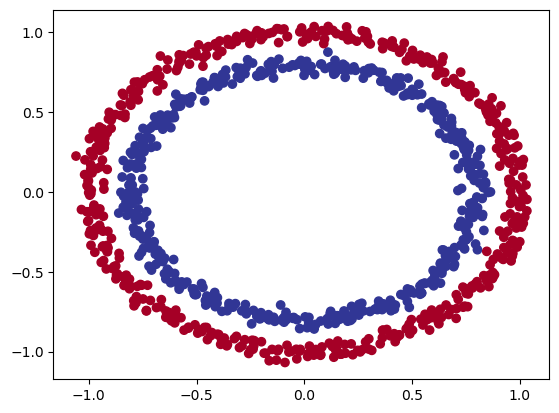

In [8]:
# Visualize Visualize Visualize with a graph instead of numbers in a table
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y, 
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

1.1 Check input and output shapes a lot of errors happen due to shapes.

In [9]:
X.shape, y.shape, type(X), type(y)

((1000, 2), (1000,), numpy.ndarray, numpy.ndarray)

In [10]:
# Convert NumPy arrays into tensors
X_sample = X[0]
y_sample = y[0]
print(f"Value for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Value for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn our data into tensors and create train and test splits

In [11]:
import torch
torch.__version__

'2.0.1'

In [12]:
# Convert NumPy arrays into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [13]:
# Split data into training and test sets 80% of data will be for training and 20% will be for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,#0.2 = 20% of data will be for test & 80% will be train
                                                    random_state=42 # random seed for reproducibility
                                                    )

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model
Let's build a model to classify our blue and red dots.
To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module` )
3. Define a loss function and optimizer
4. Creating a training and test loop

In [15]:
# Import Pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# Now we've setup device agnostic code, let's create a model that:

1. Subclasses nn.Module (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Defines a "forward()' method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target 'device'

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
        def __init__(self):
            super().__init__()
            #2. Create 2 nn.Linear layers capable of handling the shapes of our data
            self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features more features to learn
            self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

        # 3. Define a forward() method that outlines the forward pass
        def forward(self, x):
            return self.layer_2(self.layer_1(x)) # x-> layer_1 -> layer_2 -> output
        
    #4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cpu')

In [19]:
# Let's replicate the model above using nn.Sequential()
# It's an easier way of creating a Neural Network but not as flexible as subclassing nn.Module
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)
                        ).to(device) # Which in my case is cpu

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5153, -0.2522],
                      [-0.3523,  0.3067],
                      [ 0.3241, -0.1811],
                      [ 0.0038,  0.6665],
                      [-0.1760,  0.1444]])),
             ('0.bias', tensor([-0.6924, -0.2444,  0.1747,  0.4025,  0.2781])),
             ('1.weight',
              tensor([[-0.4043, -0.2014, -0.2087,  0.1707, -0.2939]])),
             ('1.bias', tensor([-0.1788]))])

In [21]:
# Make predictions with inference mode
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(
        f"Length of untrained preds samples:{len(untrained_preds)}, Shape: {untrained_preds.shape}"
    )
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of untrained preds samples:200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [22]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

###2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again.. this is problem specific.

For example for regression you might want MAE Or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)•

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use torch.nn.BCEWithLogitsLoss(), for more on what binary cross entropy (BCE) read an article about it.

For different optimizers see torch.optim



In [23]:
# Set up a loss function
# loss_fn = nn.BCELoss() # Binary Cross Entropy Loss = requires inputs to have gone through the sigmoid activation prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss() = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # Stochastic Gradient Descent

In [24]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5153, -0.2522],
                      [-0.3523,  0.3067],
                      [ 0.3241, -0.1811],
                      [ 0.0038,  0.6665],
                      [-0.1760,  0.1444]])),
             ('0.bias', tensor([-0.6924, -0.2444,  0.1747,  0.4025,  0.2781])),
             ('1.weight',
              tensor([[-0.4043, -0.2014, -0.2087,  0.1707, -0.2939]])),
             ('1.bias', tensor([-0.1788]))])

In [25]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right.

def accuracy_fn(y_true, y_pred):
    correct =  torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc



## 3. Train the model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits -> probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

Below are logits:

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax().


In [26]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
# View the first 5 outputs of the forward pass on test data

y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1038],
        [ 0.2483],
        [-0.1316],
        [ 0.1699],
        [ 0.0961]], grad_fn=<SliceBackward0>)

In [28]:
y_test[:5]


tensor([1., 0., 1., 0., 1.])

### 3.2 Build a training loop.

In [29]:
# Set for reproducibility
torch.manual_seed(42)

# Set the number of training epochs or training loops
epochs = 1000

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training Phase ###
    model_0.train()

    # 1. Forward pass with raw logits from the model
    y_logits = model_0(X_train).squeeze() # squeeze() removes any extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> prediction probability -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCEWithLogitsLoss expects raw logits as input e.g. y_logits    
    
    # 3. Calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 4. Optimizer zero grad also known as zero the gradients
    optimizer.zero_grad()

    # 5. Loss backwards backpropagation
    loss.backward()

    # 6. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass with raw logits from the model
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    # Print out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72701, Acc: 52.88% | Test loss: 0.70546, Test acc: 46.00%
Epoch: 10 | Loss: 0.72679, Acc: 52.88% | Test loss: 0.70519, Test acc: 46.50%
Epoch: 20 | Loss: 0.72658, Acc: 52.75% | Test loss: 0.70492, Test acc: 46.50%
Epoch: 30 | Loss: 0.72637, Acc: 52.75% | Test loss: 0.70467, Test acc: 47.50%
Epoch: 40 | Loss: 0.72616, Acc: 52.50% | Test loss: 0.70443, Test acc: 47.00%
Epoch: 50 | Loss: 0.72596, Acc: 52.38% | Test loss: 0.70420, Test acc: 47.00%
Epoch: 60 | Loss: 0.72575, Acc: 51.88% | Test loss: 0.70398, Test acc: 48.00%
Epoch: 70 | Loss: 0.72555, Acc: 51.25% | Test loss: 0.70378, Test acc: 47.50%
Epoch: 80 | Loss: 0.72534, Acc: 51.00% | Test loss: 0.70359, Test acc: 47.50%
Epoch: 90 | Loss: 0.72514, Acc: 51.00% | Test loss: 0.70341, Test acc: 47.50%
Epoch: 100 | Loss: 0.72494, Acc: 50.75% | Test loss: 0.70324, Test acc: 47.50%
Epoch: 110 | Loss: 0.72474, Acc: 50.75% | Test loss: 0.70309, Test acc: 47.50%
Epoch: 120 | Loss: 0.72455, Acc: 51.12% | Test loss: 0.70295, T

## 4. Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize".

To do so, we're going to import a function called 'plot_decision _boundary()'.


In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (If it's not already downloaded)

if Path("helper_functions").is_file():
    print("helper_functions.py exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



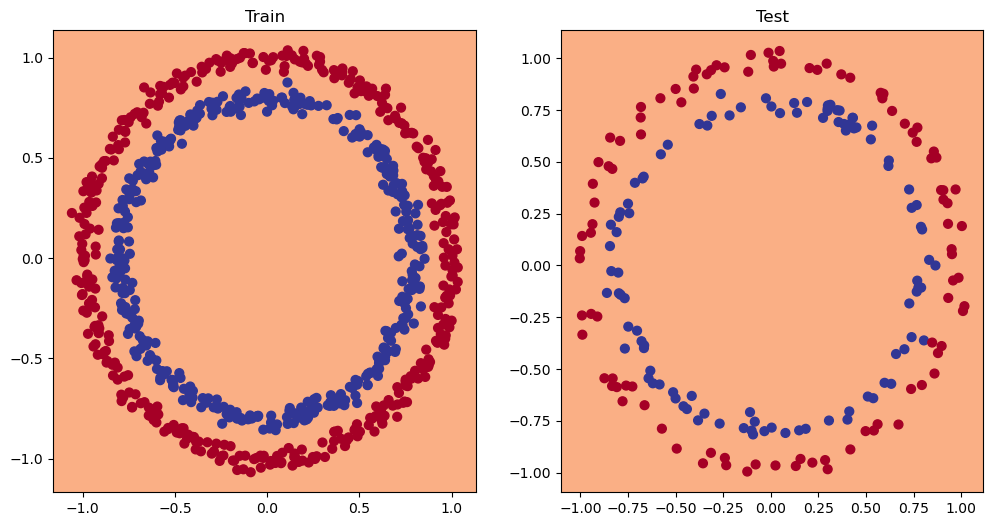

In [31]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0,
                       X_train,
                       y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0,
                       X_test,
                       y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units. 
* Fit for longer more epochs
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.
And because these options are all values we as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
• Adding more hidden units: 5 > 10
• Increase the number of layers: 2 > 3
• Increase the number of epochs: 100 > 1000

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))
    

In [33]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [35]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [36]:
# Write a training and evaluation loop for model_1
# Set for reproducibility
torch.manual_seed(42)

# Train for longer epochs
epochs = 1000

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training Phase ###
    model_1.train()

    # 1. Forward pass with raw logits from the model
    y_logits = model_1(X_train).squeeze() # squeeze() removes any extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> prediction probability -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCEWithLogitsLoss expects raw logits as input e.g. y_logits    
    
    # 3. Calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 4. Optimizer zero grad also known as zero the gradients
    optimizer.zero_grad()

    # 5. Loss backwards backpropagation
    loss.backward()

    # 6. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass with raw logits from the model
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    # Print out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72476, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.72452, Acc: 50.50% | Test loss: 0.69258, Test acc: 50.00%
Epoch: 20 | Loss: 0.72427, Acc: 50.25% | Test loss: 0.69258, Test acc: 50.50%
Epoch: 30 | Loss: 0.72403, Acc: 49.75% | Test loss: 0.69259, Test acc: 50.00%
Epoch: 40 | Loss: 0.72379, Acc: 49.62% | Test loss: 0.69261, Test acc: 50.00%
Epoch: 50 | Loss: 0.72355, Acc: 48.88% | Test loss: 0.69265, Test acc: 48.50%
Epoch: 60 | Loss: 0.72332, Acc: 48.75% | Test loss: 0.69270, Test acc: 49.50%
Epoch: 70 | Loss: 0.72308, Acc: 48.25% | Test loss: 0.69277, Test acc: 49.50%
Epoch: 80 | Loss: 0.72285, Acc: 47.75% | Test loss: 0.69286, Test acc: 49.00%
Epoch: 90 | Loss: 0.72261, Acc: 47.12% | Test loss: 0.69296, Test acc: 49.00%
Epoch: 100 | Loss: 0.72238, Acc: 46.25% | Test loss: 0.69307, Test acc: 48.00%
Epoch: 110 | Loss: 0.72215, Acc: 45.00% | Test loss: 0.69320, Test acc: 46.00%
Epoch: 120 | Loss: 0.72193, Acc: 41.38% | Test loss: 0.69334, T

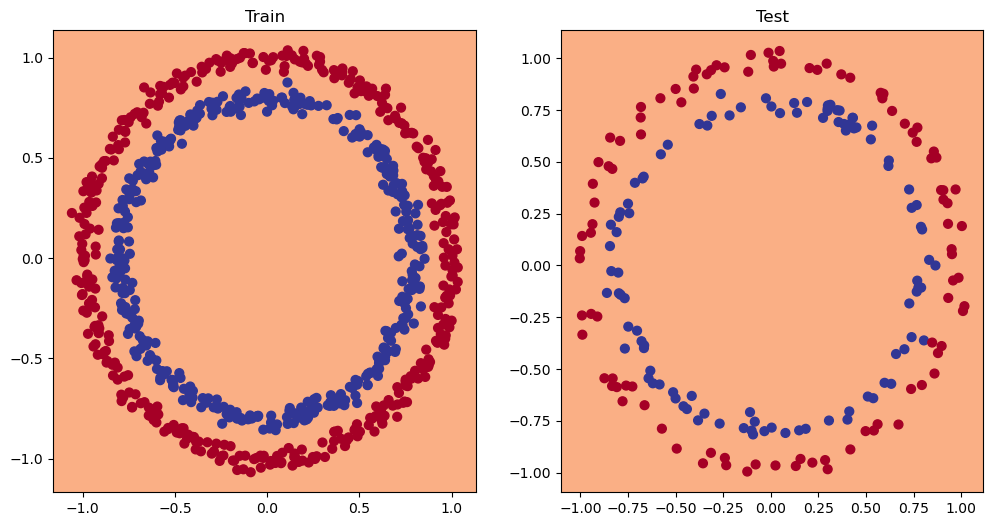

In [37]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1,
                       X_train,
                       y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1,
                       X_test,
                       y_test)

### 5.1 Preparing data to see if our model can fit a straight line
One way to troubleshoot to a larger problem is to test out a smaller problem.|

In [38]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check out the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data for training
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

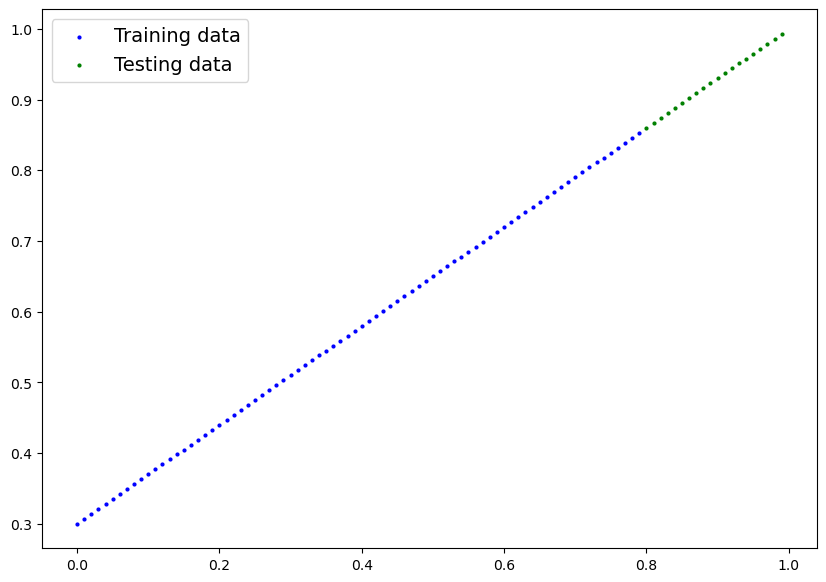

In [40]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

### 5.2 Adjusting model_1' to fit a straight line

In [41]:
# Same architecture as model_1 (but using nn.Sequential ())
model_2 = nn.Sequential(nn.Linear(in_features=1, out_features=10),
                        nn.Linear(in_features=10, out_features=10),
                        nn.Linear(in_features=10, out_features=1)).to(device)                       

In [42]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [43]:
# Train the model
torch.manual_seed(42)

# Set the number of training epochs or training loops
epochs = 1000

# Put the data to the target device (cpu)
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training Phase ###
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

        # Print out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986, Test loss: 0.91103
Epoch: 10 | Loss: 0.40240, Test loss: 0.50474
Epoch: 20 | Loss: 0.06007, Test loss: 0.10151
Epoch: 30 | Loss: 0.01559, Test loss: 0.03231
Epoch: 40 | Loss: 0.03092, Test loss: 0.00111
Epoch: 50 | Loss: 0.03196, Test loss: 0.00108
Epoch: 60 | Loss: 0.03192, Test loss: 0.00170
Epoch: 70 | Loss: 0.03081, Test loss: 0.00097
Epoch: 80 | Loss: 0.03077, Test loss: 0.00150
Epoch: 90 | Loss: 0.02967, Test loss: 0.00092
Epoch: 100 | Loss: 0.02858, Test loss: 0.00081
Epoch: 110 | Loss: 0.02962, Test loss: 0.00197
Epoch: 120 | Loss: 0.02748, Test loss: 0.00091
Epoch: 130 | Loss: 0.02852, Test loss: 0.00181
Epoch: 140 | Loss: 0.02850, Test loss: 0.00246
Epoch: 150 | Loss: 0.02744, Test loss: 0.00169
Epoch: 160 | Loss: 0.02638, Test loss: 0.00123
Epoch: 170 | Loss: 0.02637, Test loss: 0.00162
Epoch: 180 | Loss: 0.02532, Test loss: 0.00125
Epoch: 190 | Loss: 0.02636, Test loss: 0.00284
Epoch: 200 | Loss: 0.02533, Test loss: 0.00209
Epoch: 210 | Loss: 0.025

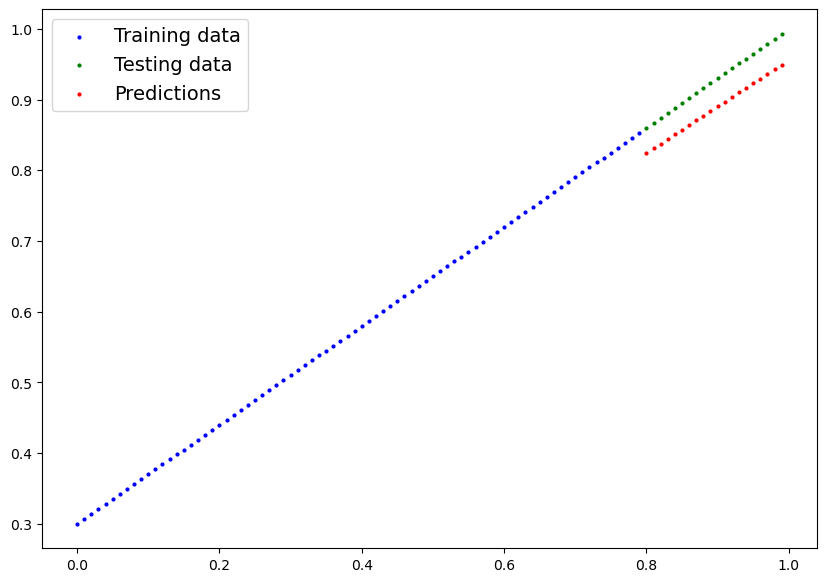

In [44]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference mode)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression, 
                 test_data=X_test_regression, 
                 test_labels=y_test_regression, 
                 predictions=y_preds)

## 6. The missing piece: non-linearity
"What patterns could you draw if you were given an infinite amount of a straight
and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) amount of linear and non-linear functions.



### 6.1 Recreating non-linear data (red and blue circles)

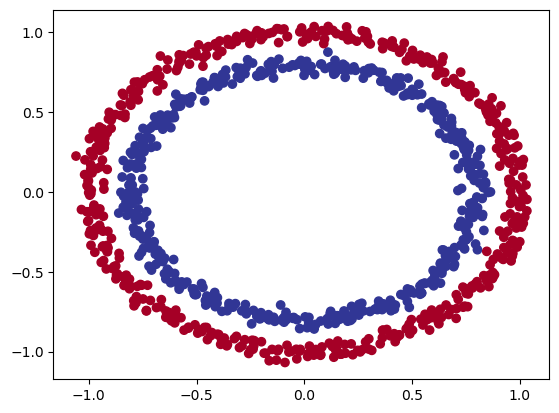

In [45]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles and added noise to so that the data isn't too perfect.
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);



In [46]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [47]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
• Linear = straight linear
• Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and
non-straight (non-linear) functions which are potentially able to find patterns in data.

In [48]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Relu

    def forward(self, x):
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity


In [50]:
# Random seeds
torch.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 10000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects logits as first input

    # 3. Calculate accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 4. Zero the gradients
    optimizer.zero_grad()

    # 5. Loss Backward
    loss.backward()

    # 6. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out the results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test loss: 0.6932, Test acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test loss: 0.6910, Test acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test loss: 0.6894, Test acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test loss: 0.6872, Test acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test loss: 0.6841, Test acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test loss: 0.6794, Test acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test loss: 0.6729, Test acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test loss: 0.6632, Test acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test loss: 0.6476, Test acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test loss: 0.6215, Test acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions.

In [51]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

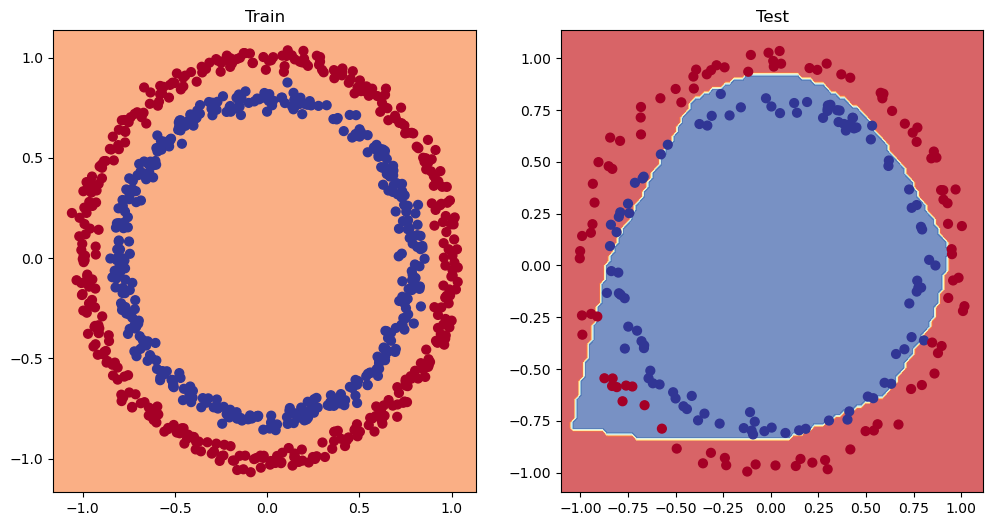

In [53]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, # model_1 is the linear model
                       X_train,
                       y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, # model_3 is the non-linear model
                       X_test,
                       y_test)